In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import skew, kurtosis, shapiro, ttest_ind, levene
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.models import load_model
set_global_policy('mixed_float16')
import optuna
from optuna.pruners import HyperbandPruner
from optuna.trial import FixedTrial
import optuna.visualization as vis
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import sys
sys.path.append('../src/bars')
from ImbalanceVolumeBars import ImbalanceVolumeBars

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9


# 🔩 1. Loading the data

In [2]:
time_bars = pd.read_csv('../data/SPY_1min_last6months.csv', parse_dates=['date'], index_col='date')

In [3]:
ivb_maker = ImbalanceVolumeBars(time_bars)
ivb_bars = ivb_maker.make_bars(alpha=0.5)
ivb_bars.columns = ['open', 'high', 'low', 'close', 'volume']

# 🧰 2. Feature Engineering
In this step, we construct a comprehensive set of technical and statistical features from the raw OHLCV data (both time bars and IV bars).  
The feature sets include:

- **Statistical rolling indicators**: moving averages, standard deviation, skewness, and kurtosis over multiple window sizes.
- **Technical indicators**: Bollinger Bands, Average True Range (ATR), and Relative Strength Index (RSI) in both simple and exponentially weighted forms.
- **Logarithmic transformations**: log-returns of prices and volumes are calculated and used as inputs.

All features are calculated for window sizes of 5, 10, 15, and 30 steps, and non-informative rows (with NaNs) are dropped after computation.

In [4]:
def make_logs(df):
    data = np.log(df)
    return data

In [5]:
class MovingIndicators:
    def __init__(self, data, windows):
        self.windows = windows
        self.data = data.copy()
        return None
        
    def _make_moving_average(self, data):
        for w in self.windows:
            data[f'ma_{w}'] = data['close'].rolling(w).mean()
    
    def _make_moving_std(self, data, windows=[]):
        for w in self.windows:
            data[f'mstd_{w}'] = data['close'].rolling(w).std()
    
    def _make_moving_skew(self, data, windows=[]):
        for w in self.windows:
            data[f'mskew_{w}'] = data['close'].rolling(w).skew()
    
    def _make_moving_kurt(self, data, windows=[]):
        for w in self.windows:
            data[f'mkurt_{w}'] = data['close'].rolling(w).kurt()

    def transform(self):
        self._make_moving_average(self.data)
        self._make_moving_std(self.data)
        self._make_moving_skew(self.data)
        self._make_moving_kurt(self.data)
        return self.data

In [6]:
class TechnicalIndicators:
    def __init__(self, data, windows):
        self.windows = windows
        self.data = data.copy()

    def _bollinger_bands(self, std_interval=2):
        for w in self.windows:
            ma = self.data['close'].rolling(w).mean()
            std = self.data['close'].rolling(w).std()
            self.data[f'upper_bollinger_{w}'] = ma + std * std_interval
            self.data[f'lower_bollinger_{w}'] = ma - std * std_interval

    def _sma_average_true_range(self):
        high = self.data['high']
        low = self.data['low']
        close = self.data['close']
        for w in self.windows:
            prev_close = close.shift(1)
            hl = high - low
            hc = (high - prev_close).abs()
            lc = (low - prev_close).abs()
            # compute True Range as a pandas Series
            tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
            self.data[f'sma_atr_{w}'] = tr.rolling(w).mean()

    def _ewm_average_true_range(self):
        high = self.data['high']
        low = self.data['low']
        close = self.data['close']
        for w in self.windows:
            prev_close = close.shift(1)
            hl = high - low
            hc = (high - prev_close).abs()
            lc = (low - prev_close).abs()
            # compute True Range as a pandas Series
            tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
            self.data[f'ewm_atr_{w}'] = tr.ewm(alpha=1/w, adjust=False).mean()

    def _rsi(self):
        close = self.data['close']
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = (-delta).clip(lower=0)
        for w in self.windows:
            avg_gain = gain.rolling(w).mean()
            avg_loss = loss.rolling(w).mean().replace(0, 1e-8)
            rs = avg_gain / avg_loss
            self.data[f'rsi_{w}'] = 100 - (100 / (1 + rs))

    def transform(self):
        self._bollinger_bands()
        self._sma_average_true_range()
        self._ewm_average_true_range()
        self._rsi()
        return self.data

In [7]:
log_time_bars = make_logs(time_bars)
log_ivb_bars = make_logs(ivb_bars)

In [8]:
time_moving_indicators= MovingIndicators(log_time_bars, windows=[5,10,15,30]).transform()
ivb_moving_indicators = MovingIndicators(log_ivb_bars, windows=[5,10,15,30]).transform()

In [9]:
time_all_indicators = TechnicalIndicators(time_moving_indicators, windows=[5,10,15,30]).transform()
ivb_all_indicators = TechnicalIndicators(ivb_moving_indicators, windows=[5,10,15,30]).transform()

In [10]:
# Transforming the logs of OHLV and Volume into log-returns
time_all_indicators.iloc[:, :5] = time_all_indicators.iloc[:, :5].diff()
ivb_all_indicators.iloc[:, :5] = ivb_all_indicators.iloc[:, :5].diff()

In [11]:
fixed_columns_names = ['lr_open', 'lr_high', 'lr_low', 'log_return', 'lr_volume', 'ma_5', 'ma_10', 'ma_15',
                       'ma_30', 'mstd_5', 'mstd_10', 'mstd_15', 'mstd_30', 'mskew_5',
                       'mskew_10', 'mskew_15', 'mskew_30', 'mkurt_5', 'mkurt_10', 'mkurt_15',
                       'mkurt_30', 'upper_bollinger_5', 'lower_bollinger_5',
                       'upper_bollinger_10', 'lower_bollinger_10', 'upper_bollinger_15',
                       'lower_bollinger_15', 'upper_bollinger_30', 'lower_bollinger_30',
                       'sma_atr_5', 'sma_atr_10', 'sma_atr_15', 'sma_atr_30', 'ewm_atr_5',
                       'ewm_atr_10', 'ewm_atr_15', 'ewm_atr_30', 'rsi_5', 'rsi_10', 'rsi_15',
                       'rsi_30']
time_all_indicators.columns = fixed_columns_names
ivb_all_indicators.columns = fixed_columns_names

In [12]:
time_dataset = time_all_indicators.dropna().copy()
ivb_dataset = ivb_all_indicators.dropna().copy()

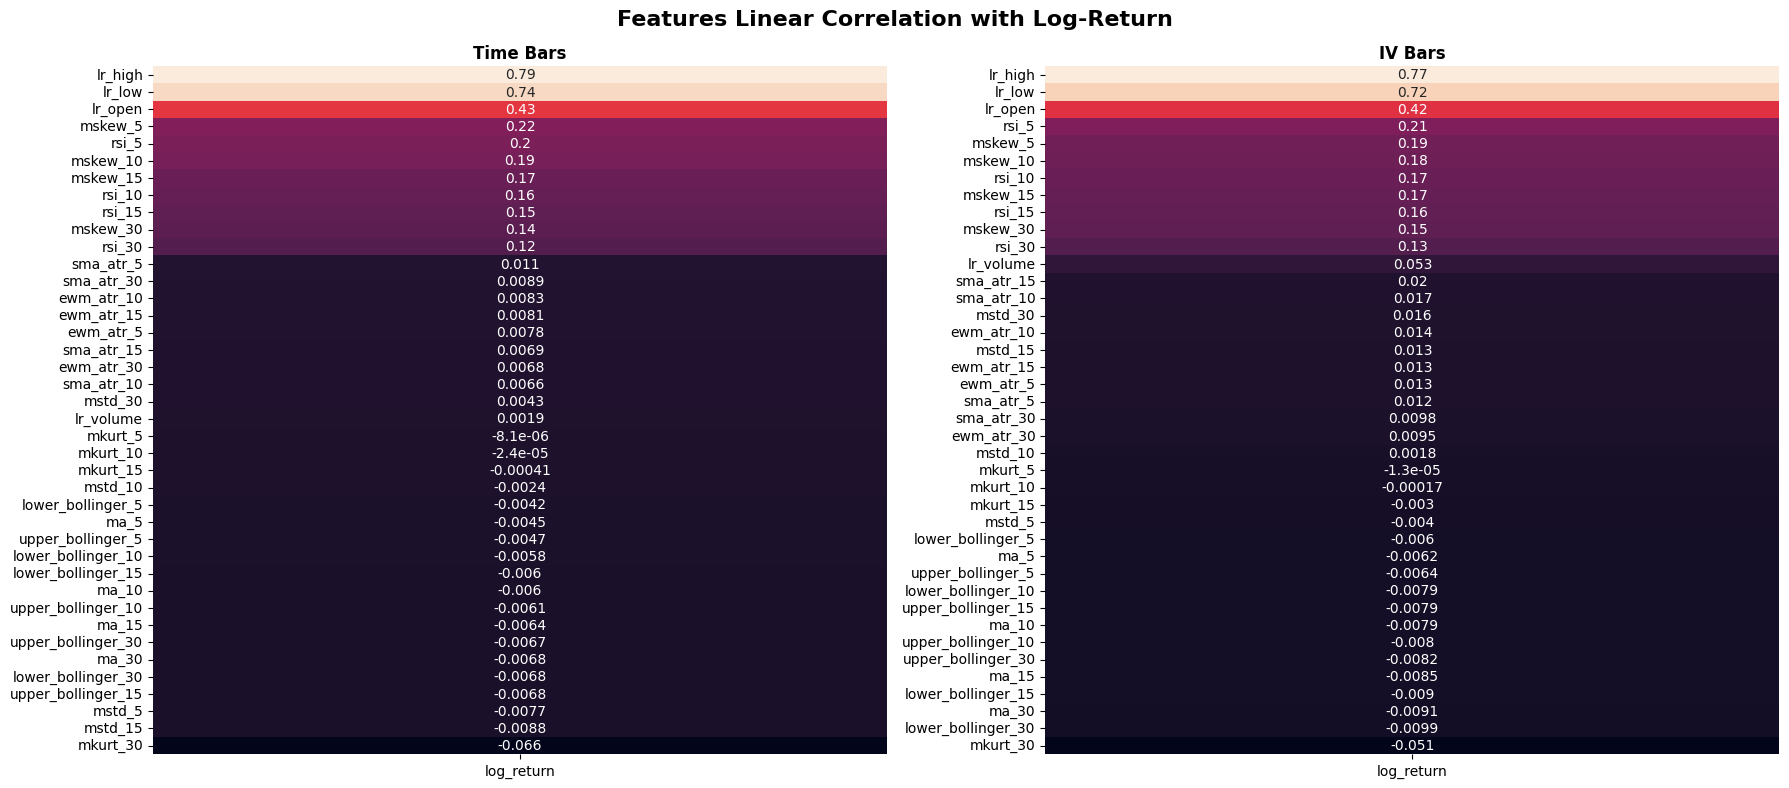

In [13]:
time_corr_with_close = time_dataset.corr()['log_return'].drop('log_return')
ivb_corr_with_close = ivb_dataset.corr()['log_return'].drop('log_return')
time_corr_df = time_corr_with_close.to_frame().sort_values('log_return', ascending=False)
ivb_corr_df = ivb_corr_with_close.to_frame().sort_values('log_return', ascending=False)

fig, ax = plt.subplots(1,2, figsize=(18,8))
sns.heatmap(time_corr_df, annot=True, cbar=False, ax=ax[0])
sns.heatmap(ivb_corr_df, annot=True, cbar=False, ax=ax[1])

fig.suptitle('Features Linear Correlation with Log-Return', weight='bold', size=16)
ax[0].set_title('Time Bars', weight='bold')
ax[1].set_title('IV Bars', weight='bold')

plt.tight_layout(pad=1.1)
plt.show()

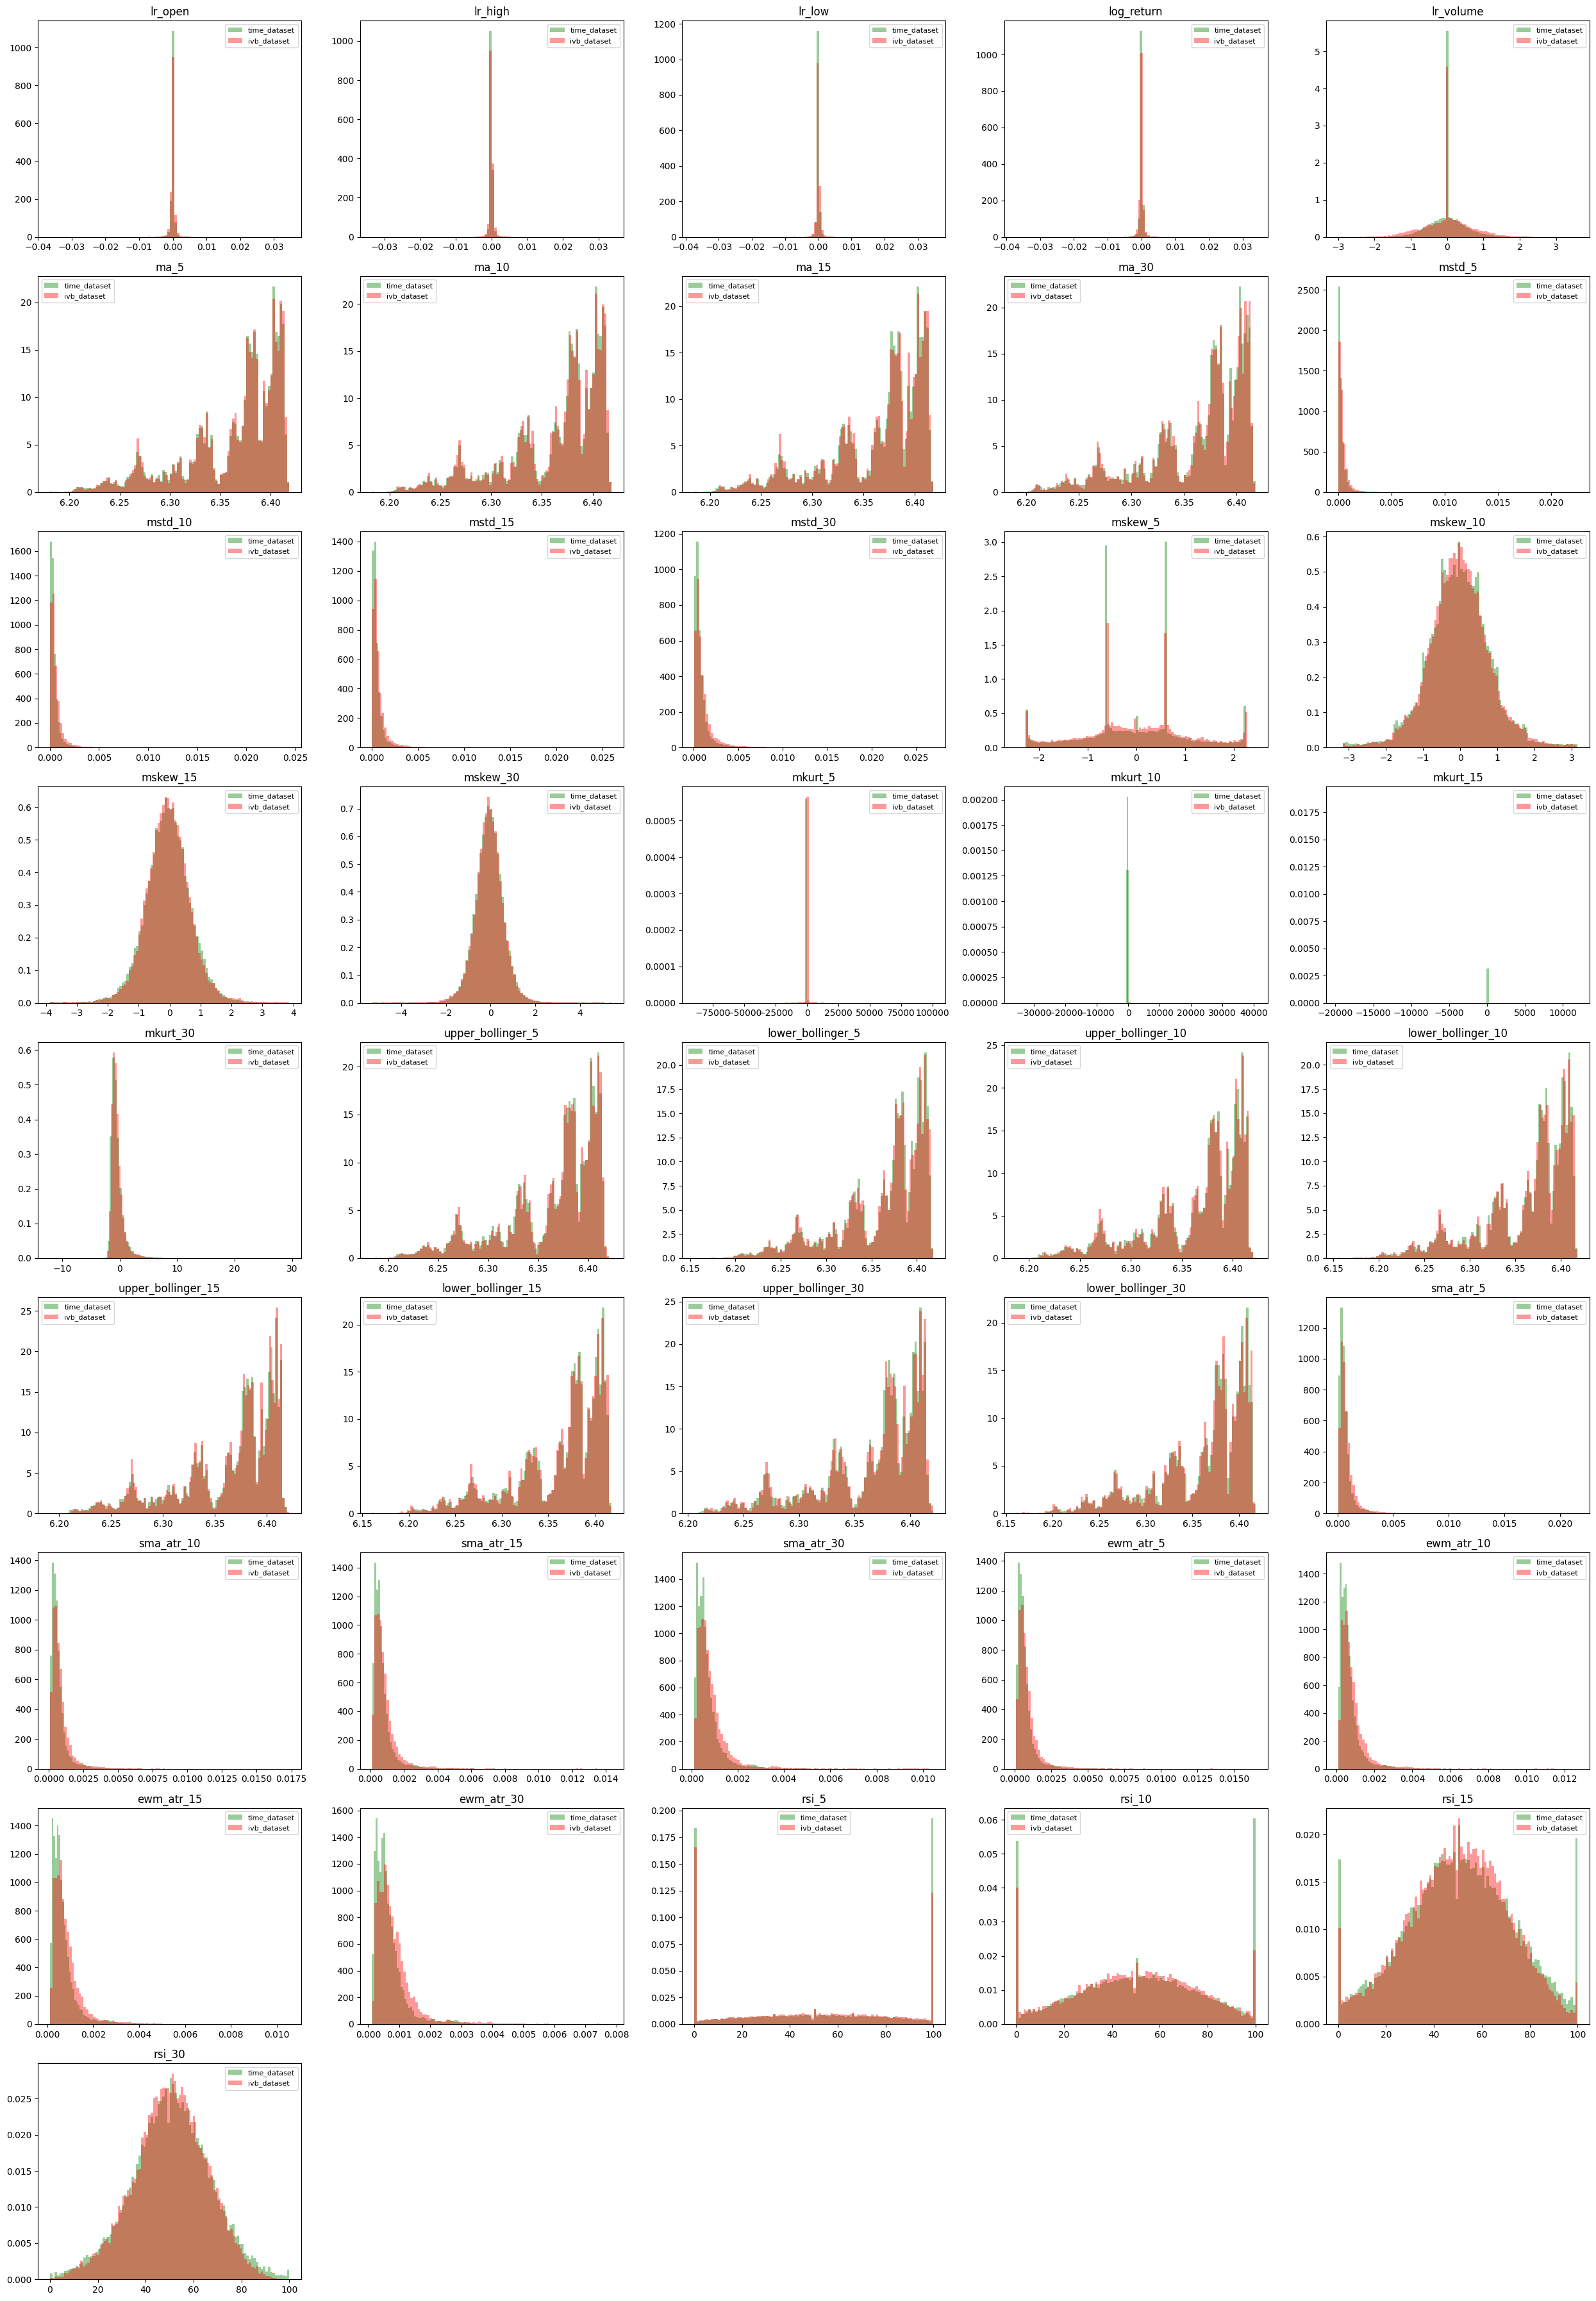

In [14]:
cols = time_dataset.columns
n_cols = len(cols)
n_rows = (n_cols + 4) // 5

fig, axes = plt.subplots(n_rows, 5, figsize=(25, n_rows * 4))
axes = axes.flatten()

bins = 100

for i, col in enumerate(cols):
    axes[i].hist(time_dataset[col], bins=bins, alpha=0.4, color='g', label='time_dataset', density=True)
    axes[i].hist(ivb_dataset[col], bins=bins, alpha=0.4, color='r', label='ivb_dataset', density=True)
    axes[i].set_title(col)
    axes[i].legend(fontsize=8)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 🧭 3. Preparing the Data for Statistical Preprocessing

## 🪚 3.1 Separating Features and Target

In [15]:
time_features = time_dataset.drop(columns='log_return')
time_target = time_dataset['log_return']
ivb_features = ivb_dataset.drop(columns='log_return')
ivb_target = ivb_dataset['log_return']

## ⛓️‍💥 3.2 Splitting the Data Into Train, Validation, and Test Sets
We split both the time-bar and imbalance volume-bar datasets into three chronological subsets:

- **Training set** (≈ 80%)
- **Validation set** (≈ 10%)
- **Test set** (≈ 10%)

This ensures that the model is trained on past data, validated on unseen but recent data, and finally evaluated on the most recent period, preserving temporal order.

In [16]:
def train_test_timeseries(features, target, test_size=0.2):
    train_size = int(len(features)*(1-test_size))
    x_train, y_train = features.iloc[:train_size], target.iloc[:train_size]
    x_test, y_test = features.iloc[train_size:], target.iloc[train_size:]
    return x_train, x_test, y_train, y_test

In [17]:
xt_train, xt_valid, yt_train, yt_valid = train_test_timeseries(time_features, time_target)
xiv_train, xiv_valid, yiv_train, yiv_valid = train_test_timeseries(ivb_features, ivb_target)

# Splitting the validation groups into 50% validation and 50% test
xt_valid, xt_test, yt_valid, yt_test = train_test_timeseries(xt_valid, yt_valid, test_size=0.5)
xiv_valid, xiv_test, yiv_valid, yiv_test = train_test_timeseries(xiv_valid, yiv_valid, test_size=0.5)

In [18]:
print (f'xt_train shape: {xt_train.shape}, xt_valid shape: {xt_valid.shape}, xt_test shape: {xt_test.shape}')
print(f'yt_train shape: {yt_train.shape}, yt_valid shape: {yt_valid.shape}, yt_test shape: {yt_test.shape}')

xt_train shape: (52440, 40), xt_valid shape: (6555, 40), xt_test shape: (6555, 40)
yt_train shape: (52440,), yt_valid shape: (6555,), yt_test shape: (6555,)


In [19]:
print (f'xiv_train shape: {xiv_train.shape}, xiv_valid shape: {xiv_valid.shape}, xiv_test shape: {xiv_test.shape}')
print(f'yiv_train shape: {yiv_train.shape}, yiv_valid shape: {yiv_valid.shape}, yiv_test shape: {yiv_test.shape}')

xiv_train shape: (27893, 40), xiv_valid shape: (3487, 40), xiv_test shape: (3487, 40)
yiv_train shape: (27893,), yiv_valid shape: (3487,), yiv_test shape: (3487,)


## 📏 3.3 Scaling the data
Since we observed that the features are not normally distributed, we apply `RobustScaler` to normalize them.  
This scaler is less sensitive to outliers and is therefore suitable for financial time series.

Separate scalers are used for:
- **Time-bar features** (`xt_*`)
- **Imbalance volume-bar features** (`xiv_*`)

We fit each scaler on the training set and apply it consistently to the validation and test sets.

In [20]:
time_scaler = RobustScaler()
ivb_scaler = RobustScaler()

In [21]:
# xt transformation:
xt_train_scaled = time_scaler.fit_transform(xt_train)
xt_valid_scaled = time_scaler.transform(xt_valid)
xt_test_scaled = time_scaler.transform(xt_test)

xiv_train_scaled = ivb_scaler.fit_transform(xiv_train)
xiv_valid_scaled = ivb_scaler.transform(xiv_valid)
xiv_test_scaled = ivb_scaler.transform(xiv_test)

## 🪟 3.4 Creating Windows
In this step, we convert the time series data into overlapping sliding windows to prepare it for supervised learning.  
Each input sample consists of a fixed historical window of features, and the target is the future value to be predicted.

We generate windowed datasets for both:
- Time-bar data (`xt_train_windows`, etc.)
- Imbalance-volume-bar data (`xiv_train_windows`, etc.)

These windowed sets will be used as inputs for the deep learning models.

In [22]:
def make_sliding_windows(features, target, window_size, forecast_horizon):
    """
    Create sliding windows for multivariate features and univariate target.

    Parameters:
        features (np.ndarray): shape (T, n_features)
        target (np.ndarray): shape (T,)
        window_size (int): number of time steps in input window
        forecast_horizon (int): steps ahead to predict

    Returns:
        x (np.ndarray): shape (num_samples, window_size, n_features)
        y (np.ndarray): shape (num_samples,)
    """
    max_start = len(features) - window_size - forecast_horizon + 1
    x, y = [], []

    for start in range(max_start):
        end = start + window_size
        x.append(features[start:end])
        y.append(target[end + forecast_horizon - 1])

    return np.array(x), np.array(y)

In [23]:
WINDOW = 60
HORIZON = 1

# creating sliding windows for the time sets
xt_train_windows, yt_train_windows =  make_sliding_windows(xt_train_scaled, yt_train.values, WINDOW, HORIZON)
xt_valid_windows, yt_valid_windows = make_sliding_windows(xt_valid_scaled, yt_valid.values, WINDOW, HORIZON)
xt_test_windows, yt_test_windows = make_sliding_windows(xt_test_scaled, yt_test.values, WINDOW, HORIZON)

# creating sliding windows for the ivb sets
xiv_train_windows, yiv_train_windows = make_sliding_windows(xiv_train_scaled, yiv_train.values, WINDOW, HORIZON)
xiv_valid_windows, yiv_valid_windows = make_sliding_windows(xiv_valid_scaled, yiv_valid.values, WINDOW, HORIZON)
xiv_test_windows, yiv_test_windows = make_sliding_windows(xiv_test_scaled, yiv_test.values, WINDOW, HORIZON)

In [24]:
print(f'xt_train_windows shape: {xt_train_windows.shape}, xt_valid_windows shape: {xt_valid_windows.shape}, xt_test_windows shape: {xt_test_windows.shape}')
print(f'yt_train_windows shape: {yt_train_windows.shape}, yt_valid_windows shape: {yt_valid_windows.shape}, yt_test_windows shape: {yt_test_windows.shape}')

xt_train_windows shape: (52380, 60, 40), xt_valid_windows shape: (6495, 60, 40), xt_test_windows shape: (6495, 60, 40)
yt_train_windows shape: (52380,), yt_valid_windows shape: (6495,), yt_test_windows shape: (6495,)


In [25]:
print(f'xiv_train_windows shape: {xiv_train_windows.shape}, xiv_valid_windows shape: {xiv_valid_windows.shape}, xiv_test_windows shape: {xiv_test_windows.shape}')
print(f'yiv_train_windows shape: {yiv_train_windows.shape}, yiv_valid_windows shape: {yiv_valid_windows.shape}, yiv_test_windows shape: {yiv_test_windows.shape}')

xiv_train_windows shape: (27833, 60, 40), xiv_valid_windows shape: (3427, 60, 40), xiv_test_windows shape: (3427, 60, 40)
yiv_train_windows shape: (27833,), yiv_valid_windows shape: (3427,), yiv_test_windows shape: (3427,)


## 💾 3.5 Preparing the data for GPU and tuning
This section standardizes and optimizes the data for deep learning workflows.  
It includes precision casting to `float32`, efficient subset selection for hyperparameter tuning,  and preparation for GPU-compatible training.

### ✂️ 3.5.1  Changing to float 32
We cast all input (X) and output (y) tensors to `tf.float32`, which is required for GPU-based model training in TensorFlow.

**Why?**
- `float64` is not efficiently supported on GPU.
- `float32` reduces memory usage and improves speed.
- Ensures consistency across all downstream training pipelines.

In [26]:
def to_float32(x, y):
    return tf.cast(x, tf.float32), tf.cast(y, tf.float32)

In [27]:
xt_train32, yt_train32 = to_float32(xt_train_windows, yt_train_windows)
xt_val32, yt_val32 = to_float32(xt_valid_windows, yt_valid_windows)
xt_test32, yt_test32 = to_float32(xt_test_windows, yt_test_windows)

xiv_train32, yiv_train32 = to_float32(xiv_train_windows, yiv_train_windows)
xiv_val32, yiv_val32 = to_float32(xiv_valid_windows, yiv_valid_windows)
xiv_test32, yiv_test32 = to_float32(xiv_test_windows, yiv_test_windows)

### ✂️ 3.5.2 Preparing Data for Hyperparameters Tuning

We extract the last percentage of samples from each dataset to use for fast and memory-efficient hyperparameter tuning.

**Why the last windows?**
-  The most recent data is usually most relevant for validation and tuning.
- Using a small recent subset speeds up Optuna without sacrificing contextual relevance.

In [28]:
def take_last_windows(x_windows, y_windows, percentage):
    """
    Returns the last `percentage` of sliding windows (x, y), preserving order.
    
    Parameters:
    - x_windows: np.ndarray or Tensor, shape (n_samples, window_size, n_features)
    - y_windows: np.ndarray or Tensor, shape (n_samples,)
    - percentage: float between 0 and 1
    
    Returns:
    - x_sub, y_sub: same types, last `percentage` of the data
    """
    total = len(x_windows)
    take_n = max(1, int(total * percentage))
    return x_windows[-take_n:], y_windows[-take_n:]

In [29]:
sub_xt_train, sub_yt_train = take_last_windows(xt_train32, yt_train32, 0.2)
sub_xt_val, sub_yt_val = take_last_windows(xt_val32, yt_val32, 0.2)

sub_xiv_train, sub_yiv_train = take_last_windows(xiv_train32, yiv_train32, 0.2)
sub_xiv_val, sub_yiv_val = take_last_windows(xiv_val32, yiv_val32, 0.2)

### 🗂 3.5.3  Prefetching the data
This section converts training and validation sets into prefetch-enabled `tf.data.Dataset` objects for efficient GPU training.

**Why prefetch?**
- Enables asynchronous data loading and preprocessing while the GPU is training.
- Reduces idle time between batches and improves throughput.
- Ensures smoother pipeline during training loops.

In [30]:
def prefetch_sets(x, y, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return dataset

In [31]:
# Prefetching sub-sets for hyperparameters tuning

## time-bars sub-sets:
sub_time_train = prefetch_sets(sub_xt_train, sub_yt_train)
sub_time_val = prefetch_sets(sub_xt_val, sub_yt_val)

## iv bars sub-sets:
sub_ivb_train = prefetch_sets(sub_xiv_train, sub_yiv_train)
sub_ivb_val = prefetch_sets(sub_xiv_val, sub_yiv_val)

### 3.5.4 Preparing the full datasets fot GPU

In [32]:
# Prefetching time-bars full setes
time_train = prefetch_sets(xt_train32, yt_train32)
time_valid = prefetch_sets(xt_val32, yt_val32)
time_test = prefetch_sets(xt_test32, yt_test32)

# Prefetching iv-bars full sets:
ivb_train = prefetch_sets(xiv_train32, yiv_train32)
ivb_valid = prefetch_sets(xiv_val32, yiv_val32)
ivb_test = prefetch_sets(xiv_test32, yiv_test32)

# ⛳️ 4. Training a Baseline Model

In this section, we define and evaluate a simple baseline model based on a **martingale process**, where the predicted value at time _t_ is assumed to be equal to the observed value at time _t - 1_.

#### Assumption:
The baseline model assumes no predictable trend:

In [33]:
def baseline(y):
    y_pred = y.shift()
    return y_pred.dropna()

In [34]:
time_baseline_pred = baseline(yt_valid)
ivb_baseline_pred = baseline(yiv_valid)

In [35]:
def evaluate_model(y_true, y_pred):
    results = {'mse': mean_squared_error(y_true, y_pred),
              'mae': mean_absolute_error(y_true, y_pred),
              'R2 score': r2_score(y_true, y_pred)}
    return results

In [36]:
time_baseline_results = evaluate_model(yt_valid[1:], time_baseline_pred)
ivb_baseline_results = evaluate_model(yiv_valid[1:], ivb_baseline_pred)

In [37]:
print(time_baseline_results)
print(ivb_baseline_results)

{'mse': 7.254037411531594e-07, 'mae': 0.0003591021928034314, 'R2 score': -1.0405677433247864}
{'mse': 1.3714376196896088e-06, 'mae': 0.0005302023879277585, 'R2 score': -1.0748227712209784}


# ♻️ 5. Neural Networks Training

In [ ]:
input_shape=(60,40)
purner = HyperbandPruner()
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
n_epochs = 12

## 🔁 5.1. LSTM Hyperparameters Tuning

This section defines a function to create an LSTM model whose structure and parameters are determined by Optuna during the hyperparameter optimization process.

#### Function: `create_lstm_model(trial, input_shape)`
This function builds an LSTM model dynamically, with several hyperparameters sampled using Optuna’s `trial` object.

#### Tuned Hyperparameters:
- **`n_layers`**: Number of LSTM layers (1 to 4)
- **`n_units_i`**: Number of units in each LSTM layer, selected from `[16, 32, 64, 128]`
- **`initializer_i`**: Kernel initializer per layer, selected from:
  - `'he_normal'`
  - `'random_normal'`
  - `'he_uniform'`
  - `'glorot_uniform'`
- **`return_sequences`**: Boolean flag determining whether the layer returns full sequences (used for all but the last LSTM layer)

#### Logic:
- The input shape is only specified in the **first** LSTM layer.
- Dropout is fixed at 0.2 after each LSTM layer.
- The final output layer is a dense layer with 1 unit and `'linear'` activation.

#### Purpose:
This flexible model architecture enables Optuna to explore various combinations of depth, width, and initialization strategies, optimizing model performance based on validation loss.

In [ ]:
def create_lstm_model(trial, input_shape):
    model = Sequential()

    n_layers = trial.suggest_int('n_layers', 1, 4)
    for i in range(n_layers):
        n_units = trial.suggest_categorical(f'n_units_{i}', [16,32,64, 128])
        initializer = trial.suggest_categorical(
            f'initializer_{i}', ['he_normal', 'random_normal', 'he_uniform', 'glorot_uniform']
        )
        return_sequences = i < n_layers - 1

        if i == 0:
            model.add(LSTM(
                units=n_units,
                activation='tanh',
                recurrent_activation='sigmoid',
                kernel_initializer=initializer,
                return_sequences=return_sequences,
                input_shape=input_shape
            ))
        else:
            model.add(LSTM(
                units=n_units,
                activation='tanh',
                recurrent_activation='sigmoid',
                kernel_initializer=initializer,
                return_sequences=return_sequences
            ))

        model.add(Dropout(0.2))

    model.add(Dense(1, activation='linear'))

    # Compilation
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'nadam'])
    optimizer = Adam(learning_rate) if optimizer_name == 'adam' else Nadam(learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [ ]:
def create_lstm_objective(train_dataset, valid_dataset, input_shape):
    def objective(trial):
        model = create_lstm_model(trial, input_shape)
        history = model.fit(train_dataset,
                            validation_data=valid_dataset,
                            epochs=n_epochs,
                            callbacks=[early_stopping],
                            verbose=0
                            )
        val_loss = min(history.history['val_loss'])
        return val_loss
    return objective

In [ ]:
# Study 1: time bars
study_time_lstm = optuna.create_study(direction='minimize', pruner=purner)
study_time_lstm.optimize(create_lstm_objective(sub_time_train, sub_time_val, input_shape), n_trials=50, timeout=1800)

In [ ]:
# Study 2: ivb bars
study_ivb_lstm = optuna.create_study(direction='minimize', pruner=purner)
study_ivb_lstm.optimize(create_lstm_objective(sub_ivb_train, sub_ivb_val, input_shape), n_trials=50, timeout=1800)

In [ ]:
time_lstm_best_params = study_time_lstm.best_params
ivb_lstm_best_params = study_ivb_lstm.best_params

In [ ]:
print(f'Time study best value: {study_time_lstm.best_value}')
print(f'IVB study best value: {study_ivb_lstm.best_value}')

## 📈 5.2. Plotting the Optimization Process

In this section, we visualize the hyperparameter optimization performed by Optuna to understand the model’s convergence behavior and hyperparameter impact.

#### Visualization 1: Optimization History
We use `optuna.visualization.plot_optimization_history()` to display how the objective value (validation loss) changes across trials. This provides insight into how quickly the optimization converges to a near-optimal solution.

  
#### Visualization 2: Hyperparameter Importance
Using `optuna.visualization.plot_param_importances()`, we evaluate the relative importance of each hyperparameter to the model’s performance. This helps identify which hyperparameters have the greatest impact on validation loss.

In [ ]:
print('Time Study Optimization History')
vis.plot_optimization_history(study_time_lstm)

In [ ]:
print('Time Study Hyperparameter Importances')
vis.plot_param_importances(study_time_lstm)

In [ ]:
print('IVB Study Optimization History')
vis.plot_optimization_history(study_ivb_lstm)

In [ ]:
print('IVB Study Hyperparamter Importance')
vis.plot_param_importances(study_ivb_lstm)

## 🥇 5.3. Instantiating Final LSTM Models with Optimal Hyperparameters

Once the hyperparameter tuning process is complete, we use the best-found parameters to initialize the final LSTM models.

Optuna's `FixedTrial` is used to simulate a `Trial` object containing the optimal values. This allows us to reuse the same model creation function (`create_lstm_model`) that was originally designed for dynamic trial suggestions.

In [ ]:
time_fixed_trial = FixedTrial(time_lstm_best_params)
time_lstm_model = create_lstm_model(time_fixed_trial, input_shape)

ivb_fixed_trial = FixedTrial(ivb_lstm_best_params)
ivb_lstm_model = create_lstm_model(ivb_fixed_trial, input_shape)

# 🚀 6. Training Final Models

In this section, we finalize the training of the LSTM models using the best hyperparameters obtained through Optuna. The models are trained with the following strategies:

- **EarlyStopping** is used to monitor validation loss and stop training if no improvement is seen for 10 consecutive epochs. This also restores the best model weights to avoid overfitting.
- **ModelCheckpoint** saves the best performing model during training (based on `val_loss`) to disk, so it can be reloaded later without retraining.

The code below trains two separate models:

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

time_checkpoint = ModelCheckpoint(filepath='time_lstm.keras',   
                                   monitor='val_loss',           
                                    save_best_only=True,          
                                    save_weights_only=False,      
                                    mode='min',               
                                    verbose=1 )

ivb_checkpoint = ModelCheckpoint(filepath='ivb_lstm.keras',   
                                   monitor='val_loss',           
                                    save_best_only=True,          
                                    save_weights_only=False,      
                                    mode='min',               
                                    verbose=1 )

In [ ]:
time_hist = time_lstm_model.fit(time_train,
                               validation_data = time_valid,
                               epochs=100,
                               callbacks=[early_stopping, time_checkpoint],
                               )

In [ ]:
ivb_hist = ivb_lstm_model.fit(ivb_train,
                               validation_data = ivb_valid,
                               epochs=100,
                               callbacks=[early_stopping, ivb_checkpoint],
                               )

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(time_hist.history['val_loss'], label='Time LSTM Validation Loss')
plt.plot(ivb_hist.history['val_loss'], label='IVB LSTM Validation Loss')

plt.title('LSTM Models Validation Sets Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
sns.despine()
plt.show()

# ⚓️ 7. Test Results

In this section, we evaluate the performance of the final LSTM models on the **test set** and compare them to their respective **baseline (martingale) models**, using two metrics:  
- **Mean Squared Error (MSE)**  
- **Mean Absolute Error (MAE)**

In [38]:
ivb_lstm_model = load_model('ivb_lstm.keras')
time_lstm_model = load_model('time_lstm.keras')

### 📌 7.1.  Predict on the Test Set  
We use the trained LSTM models to predict on the unseen test sets:
- `time_lstm_pred` for the time-based model  
- `ivb_lstm_pred` for the IVB-based model 

In [39]:
time_lstm_pred = time_lstm_model.predict(time_test)
ivb_lstm_pred = ivb_lstm_model.predict(ivb_test)

54/54 [==============================] - 3s 25ms/step


### 📌 7.2. Evaluate Model Performance  
Using a helper function `evaluate_model()`, we compute the MSE and MAE for each prediction by comparing the predicted values to the actual test set.

In [40]:
time_lstm_results = evaluate_model(yt_test[60:], time_lstm_pred)
ivb_lstm_results = evaluate_model(yiv_test[60:], ivb_lstm_pred)

### 📌 7.3. Define a Comparison Utility  
We define a utility function `compare_result_dicts()` to compare any two result dictionaries.  
For each metric:
- It prints the absolute values.
- It computes the **absolute ratio** of the values (e.g., 2.5x better).
- It computes the **difference in orders of magnitude**, using base-10 logarithm.

This function helps highlight not only which model performed better, but **how much better**.

In [41]:
def compare_result_dicts(dict1, dict2, label1="Model 1", label2="Model 2"):
    print(f"\n🔍 Comparing: {label1} vs {label2}\n")

    for key in dict1:
        val1 = dict1[key]
        val2 = dict2.get(key)
        if val2 is None:
            print(f"{key}: not found in {label2}")
            continue
        
        ratio = val1 / val2 if val2 != 0 else np.inf
        order_diff = np.log10(val1) - np.log10(val2) if val1 > 0 and val2 > 0 else np.nan

        print(f"📌 {key}:")
        print(f"   {label1}: {val1:.6g}")
        print(f"   {label2}: {val2:.6g}")
        print(f"   ➤ Ratio (abs): {ratio:.2f}x")
        print(f"   ➤ Order of Magnitude Difference: {order_diff:.2f} log10\n")


### 📌 7.4. Compare Models

1. **Time Baseline vs Time LSTM**  
   Shows how much better (or worse) the LSTM model performs compared to the naive martingale benchmark on the time-barred data.

2. **IVB Baseline vs IVB LSTM**  
   Same as above, but on imbalance volume bars.

3. **IVB LSTM vs Time LSTM**  
   Direct comparison between the two trained LSTM models to determine which feature representation leads to superior generalization on the test set.

### Time Baseline VS Time LSTM

In [42]:
compare_result_dicts(time_baseline_results, time_lstm_results, 'Time Baseline', 'Time LSTM')


🔍 Comparing: Time Baseline vs Time LSTM

📌 mse:
   Time Baseline: 7.25404e-07
   Time LSTM: 1.47035e-07
   ➤ Ratio (abs): 4.93x
   ➤ Order of Magnitude Difference: 0.69 log10

📌 mae:
   Time Baseline: 0.000359102
   Time LSTM: 0.000167175
   ➤ Ratio (abs): 2.15x
   ➤ Order of Magnitude Difference: 0.33 log10

📌 R2 score:
   Time Baseline: -1.04057
   Time LSTM: -0.00293666
   ➤ Ratio (abs): 354.34x
   ➤ Order of Magnitude Difference: nan log10



### IVB baseline VS IVB LSTM

In [43]:
compare_result_dicts(ivb_baseline_results, ivb_lstm_results, 'IVB Baseline', 'IVB LSTM')


🔍 Comparing: IVB Baseline vs IVB LSTM

📌 mse:
   IVB Baseline: 1.37144e-06
   IVB LSTM: 2.68281e-07
   ➤ Ratio (abs): 5.11x
   ➤ Order of Magnitude Difference: 0.71 log10

📌 mae:
   IVB Baseline: 0.000530202
   IVB LSTM: 0.000255874
   ➤ Ratio (abs): 2.07x
   ➤ Order of Magnitude Difference: 0.32 log10

📌 R2 score:
   IVB Baseline: -1.07482
   IVB LSTM: -0.0299855
   ➤ Ratio (abs): 35.84x
   ➤ Order of Magnitude Difference: nan log10



## IVB LSTM VS Time LSTM

In [44]:
compare_result_dicts(time_lstm_results, ivb_lstm_results, 'Time LSTM', 'IVB LSTM')


🔍 Comparing: Time LSTM vs IVB LSTM

📌 mse:
   Time LSTM: 1.47035e-07
   IVB LSTM: 2.68281e-07
   ➤ Ratio (abs): 0.55x
   ➤ Order of Magnitude Difference: -0.26 log10

📌 mae:
   Time LSTM: 0.000167175
   IVB LSTM: 0.000255874
   ➤ Ratio (abs): 0.65x
   ➤ Order of Magnitude Difference: -0.18 log10

📌 R2 score:
   Time LSTM: -0.00293666
   IVB LSTM: -0.0299855
   ➤ Ratio (abs): 0.10x
   ➤ Order of Magnitude Difference: nan log10



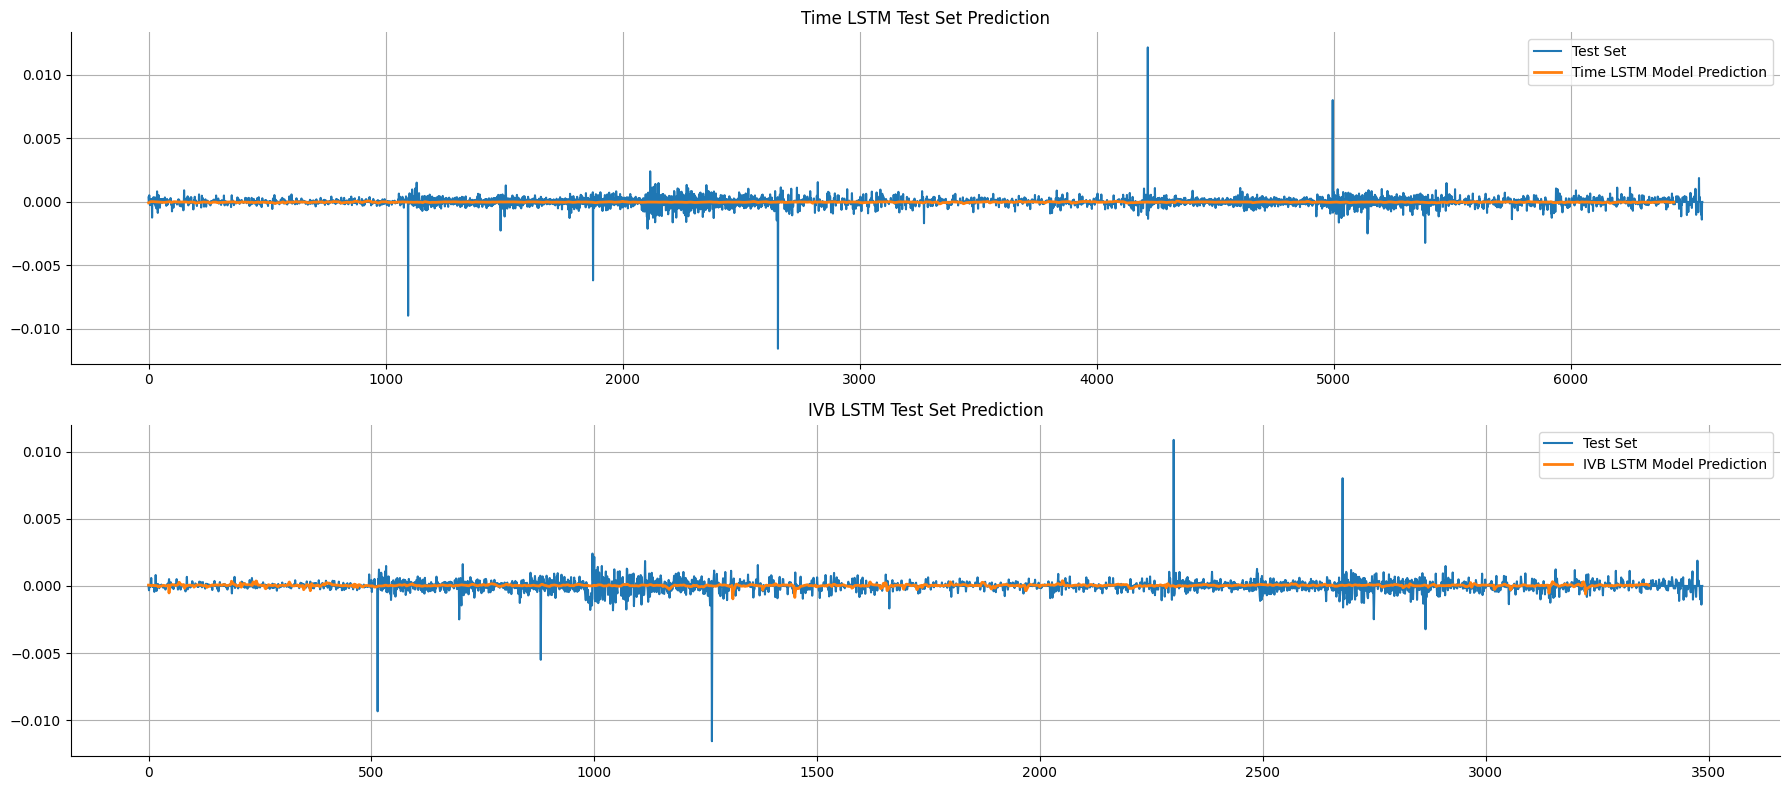

In [45]:
fig, ax = plt.subplots(2,1, figsize=(18,8))
ax[0].plot(yt_test.values, label='Test Set')
ax[0].plot(time_lstm_pred[60:], label='Time LSTM Model Prediction', lw=2)
ax[0].set_title('Time LSTM Test Set Prediction')
ax[0].grid()
ax[0].legend()

ax[1].plot(yiv_test.values, label='Test Set')
ax[1].plot(ivb_lstm_pred[60:], label='IVB LSTM Model Prediction', lw=2)
ax[1].set_title('IVB LSTM Test Set Prediction')
ax[1].grid()
ax[1].legend()

sns.despine()
plt.tight_layout()
plt.show()

# 📶 8. Residuals Analysis
This section visualizes the **residuals** (prediction errors) of the final LSTM models trained on both time bars and imbalance volume bars (IVB).

---

#### 📌 IVB LSTM Residuals

- **Top Plot:** Residuals over time — a well-centered, tightly distributed cloud indicating no visible pattern or structure.
- **Middle Plot:** Kernel Density Estimate (KDE) — reveals a sharp, nearly symmetric distribution with mean ~0.
- **Bottom Plot:** Q-Q Plot — shows slight tail deviation but overall alignment with normality assumption.

---

#### 📌 Time LSTM Residuals

- **Top Plot:** Residuals over time — reveal strong autocorrelation and structure, suggesting that the model failed to capture key time dynamics.
- **Middle Plot:** KDE — residuals are much more dispersed and less concentrated than the IVB model.
- **Bottom Plot:** Q-Q Plot — strong deviation from the theoretical quantiles, especially in the tails.

---

✅ **Interpretation**:  
While the IVB model residuals resemble white noise (i.e., desirable randomness), the Time LSTM model shows clear signs of **systematic error** and **misspecification**.

In [46]:
time_lstm_residuals = yt_test.values[60:] - time_lstm_pred.flatten()
ivb_lstm_residuals = yiv_test.values[60:] - ivb_lstm_pred.flatten()

In [47]:
def compare_distributions(series1, series2, name1='series1', name2='series2'):
    results = []

    def log(text, stat, p):
        sig = '✅ Significant' if p < 0.05 else '❌ Not Significant'
        return f'{text:<25} | stat = {stat:.4f} | p = {p:.4f} | {sig}'

    s1 = pd.Series(series1).dropna()
    s2 = pd.Series(series2).dropna()

    results.append('📊 Distribution Comparison\n')

    # 1) Shapiro-Wilk Test for normality
    stat1, p1 = shapiro(s1)
    stat2, p2 = shapiro(s2)
    results.append(log(f'Shapiro-Wilk Normality Test ({name1})', stat1, p1))
    results.append(log(f'Shapiro-Wilk Normality Test ({name2})', stat2, p2))

    # 2) T-Test for means comparison
    stat, p = ttest_ind(s1, s2, equal_var=False)
    results.append(log("Welch's T-Test Means Equality", stat, p))

    # 3) Levene's test for variance comparison
    stat, p = levene(s1, s2)
    results.append(log("Levene's Test Variance Equality", stat, p))

    return results

In [48]:
compare_distributions(time_lstm_residuals, ivb_lstm_residuals, 'time lstm residuals', 'ivb lstm residuals')

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6495.
  res = hypotest_fun_out(*samples, **kwds)


['📊 Distribution Comparison\n',
 'Shapiro-Wilk Normality Test (time lstm residuals) | stat = 0.5213 | p = 0.0000 | ✅ Significant',
 'Shapiro-Wilk Normality Test (ivb lstm residuals) | stat = 0.5958 | p = 0.0000 | ✅ Significant',
 "Welch's T-Test Means Equality | stat = 5.2964 | p = 0.0000 | ✅ Significant",
 "Levene's Test Variance Equality | stat = 111.7033 | p = 0.0000 | ✅ Significant"]

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


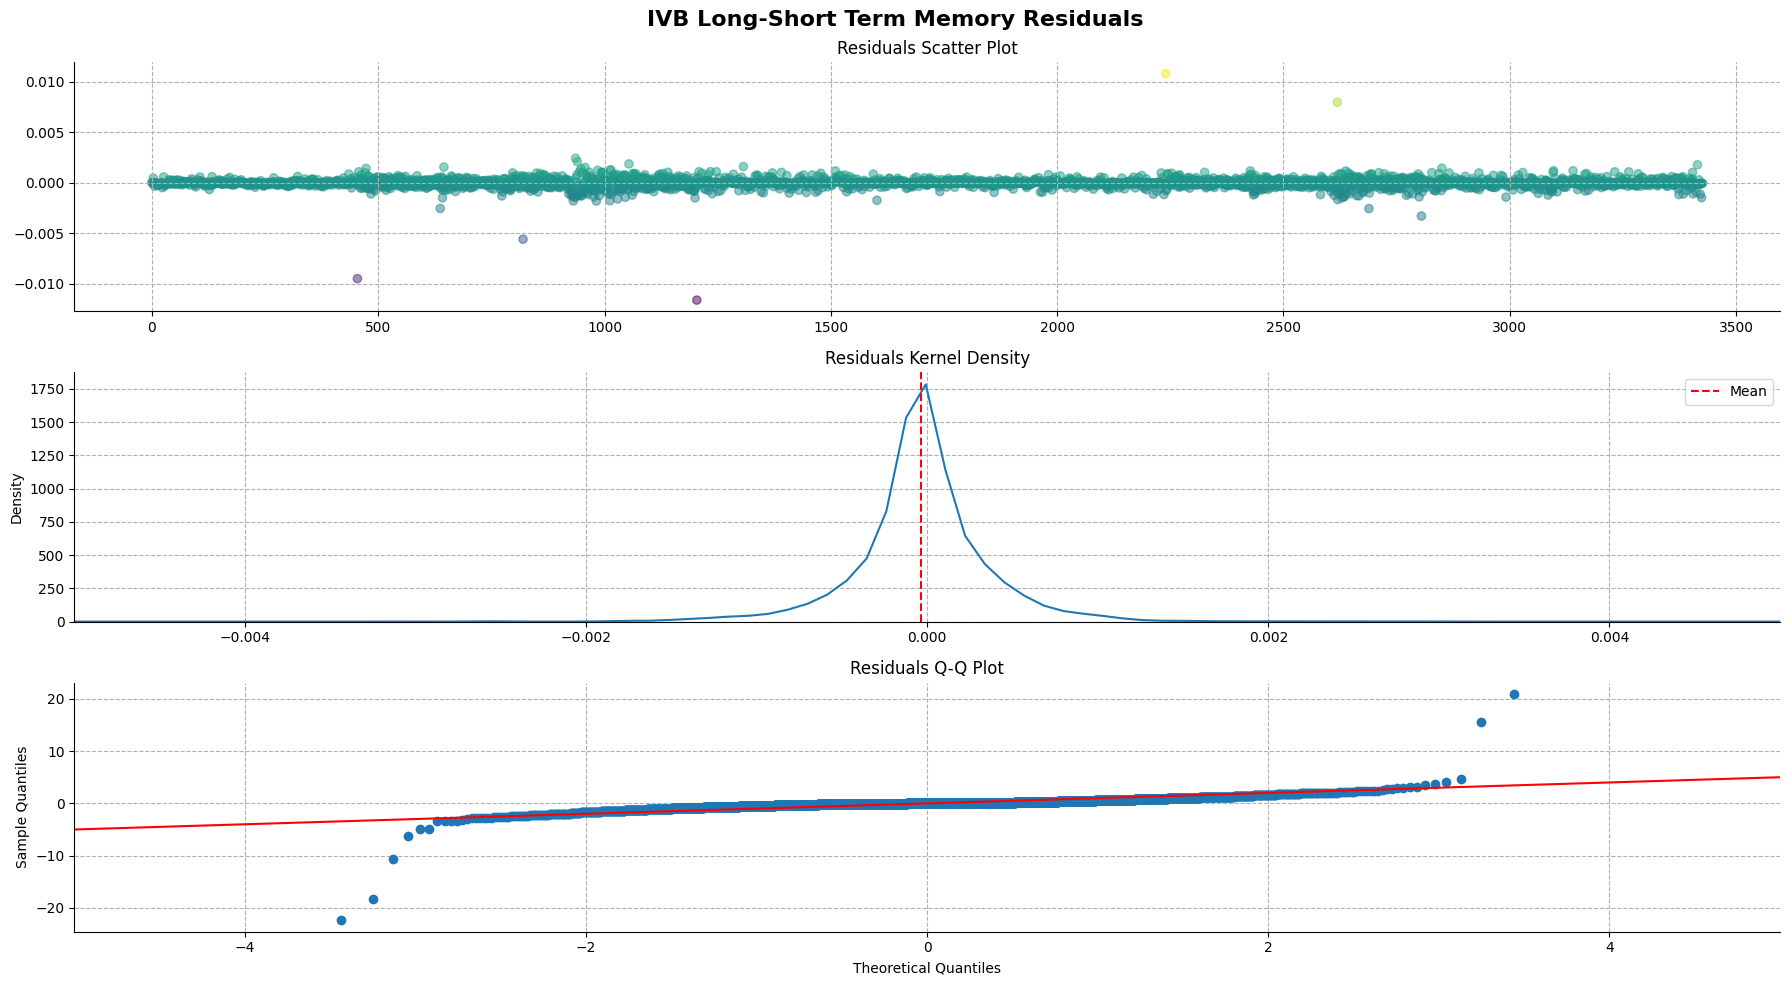

In [49]:
fig, ax = plt.subplots(3,1, figsize=(18,10))
ax[0].scatter(range(len(ivb_lstm_residuals)), ivb_lstm_residuals,
           c=ivb_lstm_residuals,
           alpha=.5)
ax[0].grid(ls='--')
ax[0].set_title('Residuals Scatter Plot')


sns.kdeplot(ivb_lstm_residuals, ax=ax[1])
ax[1].grid(ls='--')
ax[1].set_title('Residuals Kernel Density')
ax[1].axvline(np.mean(ivb_lstm_residuals), c='r', ls='--', label='Mean')
ax[1].legend()
ax[1].set_xlim(-0.005, 0.005)

sm.qqplot(ivb_lstm_residuals,line='45', fit=True, ax=ax[2])
ax[2].set_title('Residuals Q-Q Plot')
ax[2].set_xlim(-5, 5)
ax[2].grid(ls='--')

fig.suptitle('IVB Long-Short Term Memory Residuals', weight='bold', size=16)
sns.despine()
plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


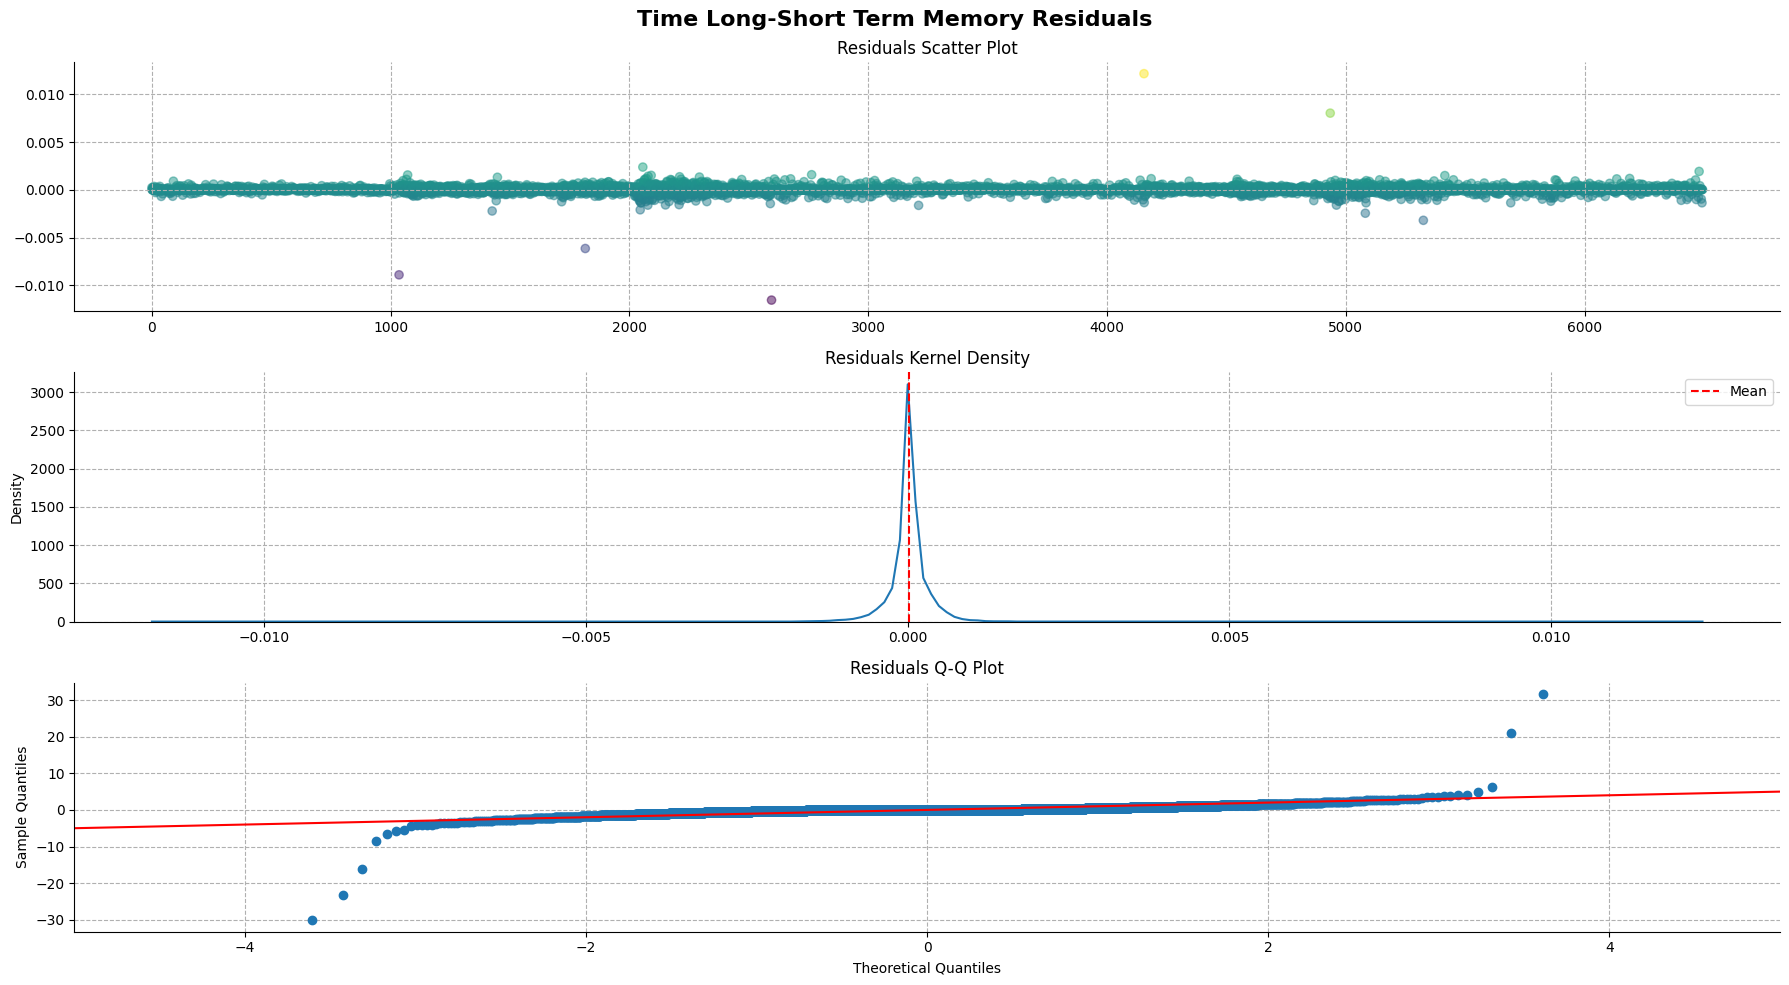

In [50]:
fig, ax = plt.subplots(3,1, figsize=(18,10))
ax[0].scatter(range(len(time_lstm_residuals)), time_lstm_residuals,
           c=time_lstm_residuals,
           alpha=.5)
ax[0].grid(ls='--')
ax[0].set_title('Residuals Scatter Plot')


sns.kdeplot(time_lstm_residuals, ax=ax[1])
ax[1].grid(ls='--')
ax[1].axvline(np.mean(time_lstm_residuals), c='r', ls='--', label='Mean')
ax[1].legend()
ax[1].set_title('Residuals Kernel Density')

sm.qqplot(time_lstm_residuals,line='45', fit=True, ax=ax[2])
ax[2].set_title('Residuals Q-Q Plot')
ax[2].set_xlim(-5, 5)
ax[2].grid(ls='--')

fig.suptitle('Time Long-Short Term Memory Residuals', weight='bold', size=16)
sns.despine()
plt.tight_layout()
plt.show()

# 🧠 Summary and Conclusions

1. **Time-based LSTM Model**  
   The LSTM model trained on time bars **failed to outperform** the martingale baseline. This indicates that the network did not manage to extract meaningful predictive patterns from time-based segmentation of the data.

2. **Imbalance-Volume-Bar (IVB) LSTM Model**  
   The LSTM model trained on imbalance volume bars **significantly outperformed** the martingale baseline:  
   - Mean Squared Error (MSE) of the martingale was **5.1 times higher**, corresponding to a difference of **0.71 orders of magnitude**.  
   - Mean Absolute Error (MAE) was **2.07 times higher**, a difference of **0.32 orders of magnitude**.  
  
3. **Direct Comparison: IVB LSTM vs Time LSTM**  
   The IVB-based model demonstrated **vastly superior performance** compared to the time-based model:  
   - MSE of the time-based model was **1843 times higher**, i.e., **3.27 orders of magnitude**.  
   - MAE was **67.5 times higher**, or **1.83 orders of magnitude**.

---

### 🎯 Residual Analysis

- Both models exhibited approximately bell-shaped residual distributions, but **Shapiro–Wilk tests rejected normality** in both cases.
- The **IVB model's residuals appear purely random**, whereas the **time-based model's residuals show strong serial structure**—a sign of unmodeled information.
- Statistical tests support this visual assessment:
  - **Welch’s t-test** confirms the residuals' means differ significantly.
  - **Levene’s test** confirms the residuals have significantly different variances.

---

# 📌 Discussion and Future Work

The results of this experiment suggest that the use of **Imbalance Volume Bars (IVB)** significantly improves the predictive performance of LSTM models over traditional **time-based bar sampling**. The IVB-trained model substantially outperformed both its baseline and the time-based LSTM in terms of **mean squared error (MSE)** and **mean absolute error (MAE)**, despite both models producing residuals that appear approximately normally distributed.

However, several important observations and limitations arise:

- **Negative \( R^2 \) values** for both LSTM models indicate that their predictions, while better than naive baselines in absolute error terms, may still be far from explaining meaningful variance in the targets. This highlights the challenge of predicting highly noisy, low-variance financial signals like short-term returns.

- The residual diagnostics suggest that the **IVB model learns a much more stationary and structure-free error**, whereas the time-bar LSTM still exhibits autocorrelated and patterned residuals – a potential sign of underfitting or temporal misalignment.

- Although the improvement in absolute errors is statistically significant, **practical relevance** remains to be tested in applied financial settings (e.g., strategy backtesting or volatility forecasting).

---

## 🔭 Suggested Future Directions

1. **Feature Engineering**: Introduce advanced technical indicators may help capture market regime changes.

2. **Model Architectures**:
   - Try GRU, Transformer, or CNN-LSTM hybrids.
   - Add attention mechanisms to focus on relevant time steps.

3. **Alternative Targets**:
   - Predict volatility or directional movement instead of raw returns.
   - Use classification (e.g., up/down movement) rather than regression.

4. **Longer Horizons**: Predict over multiple steps ahead (multi-step forecasting) and evaluate generalization over varying forecast windows.

5. **Economic Evaluation**: Incorporate financial performance metrics (e.g., Sharpe ratio, drawdowns) using backtesting to assess whether the improvement in error metrics translates to better trading outcomes.

6. **Noise Filtering**: Experiment with denoising autoencoders or signal extraction (e.g., using wavelets or Kalman filters) before applying LSTM models.

---

## 🧠 Conclusion

This work confirms that data structuring via IVB significantly affects the quality of time-series predictions using LSTM. While error reductions are encouraging, further refinement and contextual evaluation are required before deploying such models in real-world financial decision systems.


## Final Remark

The evidence strongly suggests that **sampling method matters**: the LSTM model trained on **Imbalance Volume Bars** not only beats the martingale, but also learns a much cleaner and more stable error structure than its time-based counterpart.
